In [306]:
import itertools
import time

from torch.onnx.ops import symbolic

from cirkit.symbolic.io import plot_circuit
from cirkit.templates import data_modalities
from cirkit.pipeline import compile
from notebooks.datasets import sample_rings
import matplotlib.pyplot as plt
import torch
import numpy as np


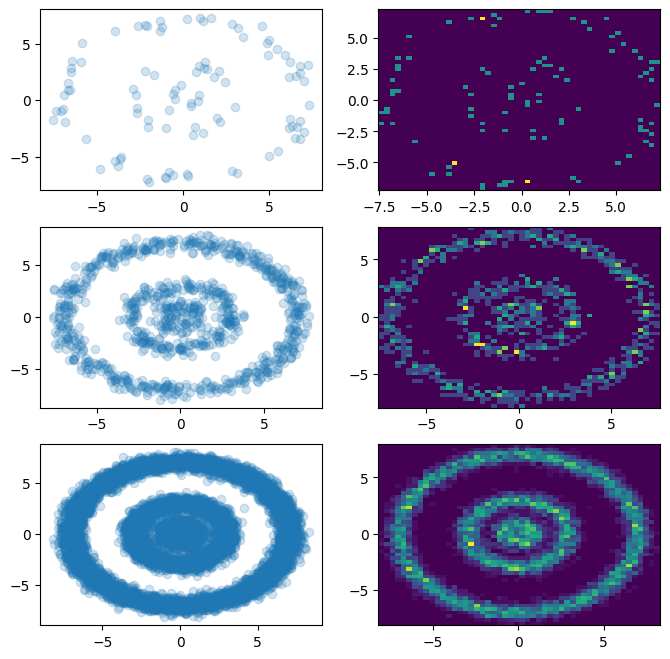

In [307]:
fig, rows = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
for (ax_scat, ax_hist), n in zip(rows, [100, 1_000, 10_000]):
    ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.4)
    ax_scat.scatter(ring_samples[:, 0], ring_samples[:, 1], alpha=0.2)
    ax_hist.hist2d(ring_samples[:, 0], ring_samples[:, 1], bins=(50, 50))

n = 10_000
ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.5)
ring_samples = np.float32(ring_samples)

In [308]:
device = torch.device("cpu")
def new_circuit():
    symbolic_circuit = data_modalities.tabular_data(
        region_graph="random-binary-tree",
        num_features=2,
        input_layers={"name": "gaussian", "args": {}},
        num_input_units=32,
        sum_product_layer="cp-t",
        num_sum_units=2,
    )
    circuit = compile(symbolic_circuit)
    circuit = circuit.to(device)
    return symbolic_circuit, circuit

symbolic_circuit, circuit = new_circuit()


Number of variables: 2
Structural properties:
 - Smoothness: True
 - Decomposability: True
 - Structured-decomposability: True
Number of layers: 2
Number of learnable parameters: 160



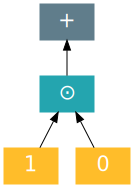

In [309]:
print(f"""
Number of variables: {symbolic_circuit.num_variables}
Structural properties:
 - Smoothness: {symbolic_circuit.is_smooth}
 - Decomposability: {symbolic_circuit.is_decomposable}
 - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}
Number of layers: {len(list(circuit.layers))}
Number of learnable parameters: {sum(p.numel() for p in circuit.parameters())}
""")
plot_circuit(symbolic_circuit)

Full-batch time: 6305ms
Minibatch time: 2272ms


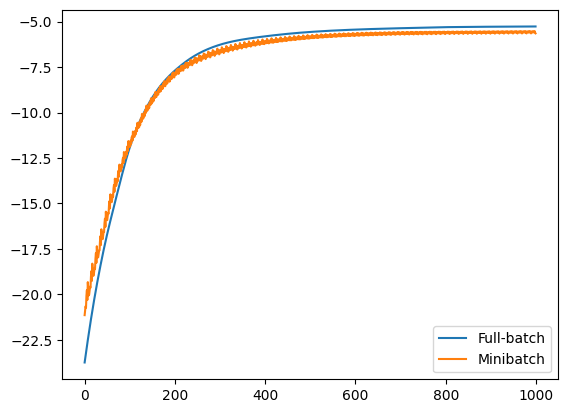

In [310]:
from torch import optim

symbolic_circuit, circuit = new_circuit()
optimizer = optim.Adam(circuit.parameters(), lr=0.01)
LLs_fullbatch = []
time_fullbatch = time.time()
for epoch_idx in range(1000):
    batch = ring_samples
    batch = torch.from_numpy(batch).to(device)

    log_likelihoods = circuit(batch)

    loss = -torch.mean(log_likelihoods)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    LLs_fullbatch.append(-loss.detach())
time_fullbatch = time.time() - time_fullbatch


symbolic_circuit, circuit = new_circuit()
optimizer = optim.Adam(circuit.parameters(), lr=0.01)
LLs_minibatch = []
time_minibatch = time.time()
for epoch_idx in range(100):
    for i, batch in enumerate(np.vsplit(ring_samples, 10)):
        batch = torch.from_numpy(batch).to(device)

        log_likelihoods = circuit(batch)

        loss = -torch.mean(log_likelihoods)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        LLs_minibatch.append(-loss.detach())
time_minibatch = time.time() - time_minibatch

print(f"Full-batch time: {time_fullbatch * 1000:.0f}ms")
print(f"Minibatch time: {time_minibatch * 1000:.0f}ms")

plt.plot(np.arange(len(LLs_fullbatch)), LLs_fullbatch, label="Full-batch")
plt.plot(np.arange(len(LLs_minibatch)), LLs_minibatch, label="Minibatch")
plt.legend()
plt.show()

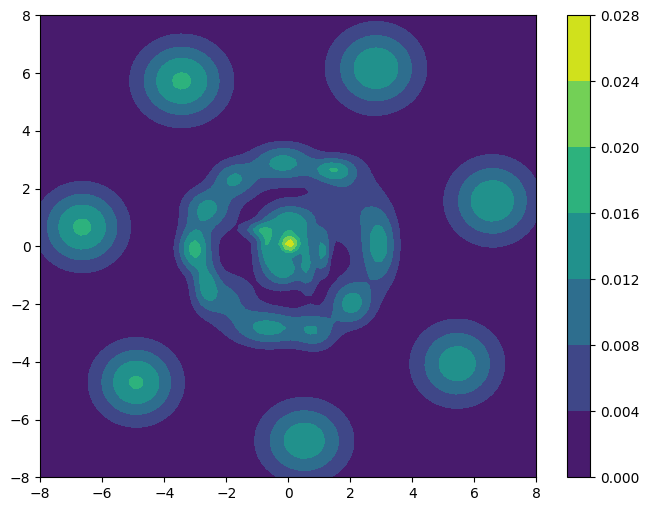

In [311]:
x = np.float32(np.linspace(-8, 8, 100))
y = np.float32(np.linspace(-8, 8, 100))

X, Y = np.meshgrid(x, y)

xy = itertools.product(x, y)
xy = torch.tensor(list(xy))
Z = circuit(xy).detach().exp().numpy().reshape(100, 100)

plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z)
plt.colorbar();